In [1]:
import git
import time
import pandas as pd
from datetime import datetime, timedelta, date
import io

In [2]:


REPO_DIR_NAME = "/Users/saksun/work/COVID-19"
REMOTE_URL = "https://github.com/CSSEGISandData/COVID-19.git"
start_date = datetime(2021, 8, 7)
end_date = datetime(2021, 8, 9)
predictionFilePath= "data/predictions/predicted_us_deaths_2021-08-01.csv"
skip_day_predictions =  564
model_day_offset=544



 
def init():
    repo = git.Repo.init(REPO_DIR_NAME)    
    repo.remotes[0].fetch()
    repo.remotes[0].pull()

def is_exists(filename, sha):
    repo = git.Repo(REPO_DIR_NAME)
    """Check if a file in current commit exist."""
    files = repo.git.show("--pretty=", "--name-only", sha)
    if filename in files:
        return True
    
def get_file_commits(filename, commits):
    file_commits = []
    for commit in commits:
        if is_exists(filename, commit.hexsha):
            file_commits.append(commit)
    return file_commits

def getDataFrame(filename):
    repo = git.Repo(REPO_DIR_NAME)
    commits = list(repo.iter_commits("master"))
    covid_file_commits = get_file_commits(filename, commits)


    current_time =   datetime(2020, 1, 1)
    prev_commit_datetime = current_time
    prev_commit = covid_file_commits[0]    
    i = 0
    fipsArray =[]
    for file_commit in reversed(covid_file_commits):
        file_commit = repo.commit(file_commit.hexsha)
        commit_datetime_str = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(file_commit.committed_date))
        commit_datetime = datetime.strptime(commit_datetime_str, '%Y-%m-%d %H:%M:%S')
        
        if  (((commit_datetime.date() != prev_commit_datetime.date())  
             and prev_commit_datetime.date() > start_date.date())
             and (commit_datetime.date() <= end_date.date())) :
            
            if commit_datetime.date() == date.today():
                prev_commit= file_commit
                prev_commit_datetime = commit_datetime
                
            print("Current commit: ", prev_commit_datetime," : ",
                 prev_commit.message.replace('\n', ' ') )
            # Retrieve a file from the commit tree
            # You can use the path helper to get the file by filename 
            targetfile = prev_commit.tree / filename
            
            with io.BytesIO(targetfile.data_stream.read()) as f:
                if i == 0:
                    US_Covid_df = pd.read_csv(f)
                    #US_Covid_df = US_Covid_df.drop(US_Covid_df[US_Covid_df["Province_State"] == "Puerto Rico"].index)
                    
                    #US_Covid_df.reset_index(drop=True, inplace=True)
                    i =  i + 1
                else:
                    df = pd.read_csv(f)
                    #df = df.drop(df[df["Province_State"] == "Puerto Rico"].index)
                    #df.reset_index(drop=True, inplace=True)
                    dd = (prev_commit_datetime.date() -  timedelta(days=1)).strftime('%-m/%-d/%y')
                    US_Covid_df[dd] = 0
                    for index, row in US_Covid_df.iterrows():
                        val = df.loc[df['FIPS'] == row["FIPS"]][dd]
                        if type(val) is int:
                            US_Covid_df.at[index,dd] = val
                        else:
                            for v in val.values:
                                US_Covid_df.at[index,dd] = v
                        
                    
        prev_commit= file_commit
        prev_commit_datetime = commit_datetime
    US_Covid_df = US_Covid_df.reset_index()
    return US_Covid_df
init()
#Read US Covid deaths
US_Deaths_df_all = getDataFrame('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
#Read US Covid cases
US_Cases_df_all = getDataFrame('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')


Current commit:  2021-08-09 00:51:20  :  Automated update 
Current commit:  2021-08-09 00:51:20  :  Automated update 


In [3]:
import datetime as dt
import pandas as pd
import  plotly.express as px 
import plotly.graph_objects as go

US_Deaths_df = US_Deaths_df_all.copy()
US_Cases_df = US_Cases_df_all.copy()
#US_Deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
#US_Deaths_df = pd.read_csv(US_Deaths_url, error_bad_lines=True)
US_Deaths_df=US_Deaths_df.drop(columns=['index','UID','iso2','iso3','code3','Admin2', 'Country_Region','Lat','Long_','Combined_Key'])
US_Deaths_df=US_Deaths_df.fillna(0)
US_Deaths_df=US_Deaths_df.melt(id_vars=["FIPS","Population","Province_State"], 
        var_name="Date", 
        value_name="Value")

#Confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
#US_Cases_df = pd.read_csv(Confirmed_url, error_bad_lines=True)
US_Cases_df=US_Cases_df.drop(columns=['index','UID','iso2','iso3','code3','Admin2', 'Province_State', 'Country_Region','Lat','Long_','Combined_Key'])
US_Cases_df=US_Cases_df.fillna(0)#US_Cases_df.dropna(subset=['FIPS'])
US_Cases_df=US_Cases_df.melt(id_vars=['FIPS'], 
        var_name="Date", 
        value_name="Value")

    
US_Cases_df.iloc[:, 1] = pd.to_datetime(US_Cases_df.iloc[:, 1])
US_Cases_df.iloc[:, 1]  = (US_Cases_df.iloc[:, 1]  - US_Cases_df['Date'].iloc[0]).dt.days
US_Cases_df = US_Cases_df.rename(columns={'Date': 'Days', 'Value':'Cumulative_Cases'})
    

US_Deaths_df.iloc[:, 3] = pd.to_datetime(US_Deaths_df.iloc[:, 3])
US_Deaths_df.iloc[:, 3]  = (US_Deaths_df.iloc[:, 3]  - US_Deaths_df['Date'].iloc[0]).dt.days
US_Deaths_df = US_Deaths_df.rename(columns={'Date': 'Days', 'Value':'Cumulative_Deaths' })
print("max_day:" , US_Deaths_df['Days'].max())

US_Predicted_Deaths = pd.read_csv(predictionFilePath,usecols=['FIPS','Population','State', 'Days','Predicted_Cumulative_Deaths']) 
US_Predicted_Deaths_Future = US_Predicted_Deaths[US_Predicted_Deaths["Days"] > skip_day_predictions]
US_Predicted_Deaths_Future.rename(columns = {'State':'Province_State', 
                                      'Predicted_Cumulative_Deaths':'Cumulative_Deaths'}, inplace = True)
US_Deaths_df = pd.concat([US_Deaths_df, US_Predicted_Deaths_Future])

US_Predicted_Cases = pd.read_csv(predictionFilePath,usecols=['FIPS', 'Days','Predicted_Cumulative_Cases'])
US_Predicted_Cases_Future = US_Predicted_Cases[US_Predicted_Cases["Days"] > skip_day_predictions]
US_Predicted_Cases_Future.rename(columns = { 'Predicted_Cumulative_Cases':'Cumulative_Cases'}, inplace = True)
US_Cases_df = pd.concat([US_Cases_df, US_Predicted_Cases_Future])
print("max_day:" , US_Deaths_df['Days'].max())

#for index, row in US_Predicted_Deaths.iterrows():
#    print(index)
#    US_Deaths_df = US_Deaths_df.append({"FIPS": row["FIPS"], "Population":0, "Province_State": row["State"], "Days": row["Days"], "Cumulative_Deaths":row["Predicted_Cumulative_Deaths"]}, ignore_index=True)
#    US_Cases_df = US_Cases_df.append({"FIPS": row["FIPS"], "Days": row["Days"], "Cumulative_Cases" : row["Predicted_Cumulative_Cases"]}, ignore_index=True) 

#US_Deaths_df['Weekly_Deaths'] = US_Deaths_df.groupby(['FIPS', 'Week'])['Cumulative_Deaths'].transform(lambda x: (x.iat[-1] - x.iat[0]))
US_Deaths_df['Weekly_Deaths'] = 0
US_Deaths_df['Weekly_Deaths_Per'] = 0.0
US_Deaths_df['Past_Week_Cumulative_Deaths'] = 0
US_Deaths_df = US_Deaths_df.reset_index()
US_Deaths_df.sort_values(by=['FIPS','Days'], inplace=True)
cdArray = US_Deaths_df['Cumulative_Deaths'].to_numpy()
fipsArray = US_Deaths_df['FIPS'].to_numpy()
i = 0
j = 0
FIPS = 0.0
for index, row in US_Deaths_df.iterrows():
  countyFIPS = row['FIPS']
  if FIPS == countyFIPS: 
    if j > 6 and fipsArray[i-7] == countyFIPS :
        previous_cum_deaths = cdArray[i-7]
        weekly_deaths = row['Cumulative_Deaths'] - previous_cum_deaths
        US_Deaths_df.at[index,'Weekly_Deaths'] =  weekly_deaths
        if previous_cum_deaths  == 0:
          previous_cum_deaths = 1
        US_Deaths_df.at[index, 'Past_Week_Cumulative_Deaths'] = previous_cum_deaths
        US_Deaths_df.at[index, 'Weekly_Deaths_Per'] = (weekly_deaths  * 1.00000) / (previous_cum_deaths * 1.00000)
  else:
    FIPS = countyFIPS
    j = 0 
    US_Deaths_df.at[index,'Weekly_Deaths'] = 0
  i = i + 1
  j = j + 1
    



    
US_Cases_df['Weekly_Cases'] = 0
US_Cases_df['Weekly_Cases_Per'] = 0.0
US_Cases_df['Past_Week_Cumulative_Cases'] = 0
US_Cases_df = US_Cases_df.reset_index()
US_Cases_df.sort_values(by=['FIPS','Days'], inplace=True)
cdArray = US_Cases_df['Cumulative_Cases'].to_numpy()
fipsArray = US_Cases_df['FIPS'].to_numpy()
i = 0
j = 0
for index, row in US_Cases_df.iterrows():
  countyFIPS = row['FIPS']
  if FIPS == countyFIPS: 
    if j > 6 and fipsArray[i-7] == countyFIPS :
        previous_cum_cases = cdArray[i-7]
        weekly_cases = row['Cumulative_Cases'] - previous_cum_cases
        US_Cases_df.at[index,'Weekly_Cases'] =  weekly_cases
        if previous_cum_cases  == 0:
          previous_cum_cases = 1
        US_Cases_df.at[index, 'Past_Week_Cumulative_Cases'] = previous_cum_cases
        US_Cases_df.at[index, 'Weekly_Cases_Per'] = (weekly_cases * 100.0) / (previous_cum_cases * 1.0)
  else:
    FIPS = countyFIPS
    j = 0
    US_Cases_df.at[index,'Weekly_Cases'] = 0
  i = i + 1
  j = j + 1
    
mobility = pd.read_csv('https://raw.githubusercontent.com/COVIDExposureIndices/COVIDExposureIndices/master/dex_data/county_dex.csv')
mobility.iloc[:, 1] = pd.to_datetime(mobility.iloc[:, 1])
mobility.iloc[:, 1]  = (mobility.iloc[:, 1]  - mobility['date'].iloc[0]).dt.days
mobility = mobility.rename(columns={'date': 'Days'})
mobility["Days"] = mobility["Days"] + 14


max_day: 564


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


max_day: 585


In [4]:
max_days = US_Deaths_df['Days'].max()    
US_Deaths_Tail_Rows = US_Deaths_df[US_Deaths_df["Days"] > max_days - 7]
US_Deaths_Tail_Rows["Days"] = US_Deaths_Tail_Rows["Days"] + 7 
US_Deaths_Tail_Rows["Past_Week_Cumulative_Deaths"] = US_Deaths_Tail_Rows["Cumulative_Deaths"] 
#US_Deaths_Tail_Rows["Weekly_Deaths"] = 0
#US_Deaths_Tail_Rows["Weekly_Deaths_Per"] = 0
US_Deaths_df = pd.concat([US_Deaths_Tail_Rows, US_Deaths_df])
US_Deaths_df.sort_values(by=['FIPS','Days'], inplace=True)

#max_days = US_Deaths_df['Days'].max()    
#US_Deaths_Tail_Rows = US_Deaths_df[US_Deaths_df["Days"] > max_days - 8]
#US_Deaths_Tail_Rows["Days"] = US_Deaths_Tail_Rows["Days"] + 8
#US_Deaths_Tail_Rows["Cumulative_Deaths"] = 0
#US_Deaths_Tail_Rows["Past_Week_Cumulative_Deaths"] = 0
#US_Deaths_Tail_Rows["Weekly_Deaths"] = 0
#US_Deaths_Tail_Rows["Weekly_Deaths_Per"] = 0
#US_Deaths_df = pd.concat([US_Deaths_Tail_Rows, US_Deaths_df])
#US_Deaths_df.sort_values(by=['FIPS','Days'], inplace=True)


max_days = US_Cases_df['Days'].max()    
US_Cases_Tail_Rows = US_Cases_df[US_Cases_df["Days"] > max_days - 7]
US_Cases_Tail_Rows["Days"] = US_Cases_Tail_Rows["Days"] + 7
US_Cases_Tail_Rows["Past_Week_Cumulative_Cases"] = US_Cases_Tail_Rows["Cumulative_Cases"]
#US_Cases_Tail_Rows["Weekly_Cases"] = 0
#US_Cases_Tail_Rows["Weekly_Cases_Per"] = 0
US_Cases_df = pd.concat([US_Cases_Tail_Rows, US_Cases_df])
US_Cases_df.sort_values(by=['FIPS','Days'], inplace=True)

#max_days = US_Cases_df['Days'].max()    
#US_Cases_Tail_Rows = US_Cases_df[US_Cases_df["Days"] > max_days - 8]
#US_Cases_Tail_Rows["Days"] = US_Cases_Tail_Rows["Days"] + 8
#US_Cases_Tail_Rows["Cumulative_Cases"] = 0
#US_Cases_Tail_Rows["Past_Week_Cumulative_Cases"] = 0
#US_Cases_Tail_Rows["Weekly_Cases"] = 0
#US_Cases_Tail_Rows["Weekly_Cases_Per"] = 0
#US_Cases_df = pd.concat([US_Cases_Tail_Rows, US_Cases_df])
#US_Cases_df.sort_values(by=['FIPS','Days'], inplace=True)


US_Deaths_df.to_csv("usdf.csv")
US_Cases_df.to_csv("uscf.csv")

<ipython-input-4-2c5a314e1a7d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_Deaths_Tail_Rows["Days"] = US_Deaths_Tail_Rows["Days"] + 7
<ipython-input-4-2c5a314e1a7d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_Deaths_Tail_Rows["Past_Week_Cumulative_Deaths"] = US_Deaths_Tail_Rows["Cumulative_Deaths"]
<ipython-input-4-2c5a314e1a7d>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [5]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [6]:
unassigned_fips = [  0.0, 60.0,    66.0,    69.0,    78.0,  2013.0,  2261.0, 72001.0,  72003.0,  72005.0,
 72007.0,  72009.0,  72011.0,  72013.0,  72015.0,  72017.0,  72019.0,  72021.0,  72023.0,  72025.0,
 72027.0,  72029.0,  72031.0,  72033.0,  72035.0,  72037.0,  72039.0,  72041.0,  72043.0,  72045.0,
 72047.0,  72049.0,  72051.0,  72053.0,  72054.0,  72055.0,  72057.0,  72059.0,  72061.0,  72063.0,
 72065.0,  72067.0,  72069.0,  72071.0,  72073.0,  72075.0,  72077.0,  72079.0,  72081.0,  72083.0,
 72085.0,  72087.0,  72089.0,  72091.0,  72093.0,  72095.0,  72097.0,  72099.0,  72101.0,  72103.0,
 72105.0,  72107.0,  72109.0,  72111.0,  72113.0,  72115.0,  72117.0,  72119.0,  72121.0,  72123.0,
 72125.0,  72127.0,  72129.0,  72131.0,  72133.0,  72135.0,  72137.0,  72139.0,  72141.0,  72143.0,
 72145.0,  72147.0,  72149.0,  72151.0,  72153.0,  72888.0,  72999.0,  80001.0, 80002.0, 80004.0, 80005.0,
 80006.0, 80008.0, 80009.0, 80010.0, 80011.0, 80012.0, 80013.0, 80015.0, 80016.0, 80017.0,
 80018.0, 80019.0, 80020.0, 80021.0, 80022.0, 80023.0, 80024.0, 80025.0, 80026.0, 80027.0,
 80028.0, 80029.0, 80030.0, 80031.0, 80032.0, 80033.0, 80034.0, 80035.0, 80036.0, 80037.0,
 80038.0, 80039.0, 80040.0, 80041.0, 80042.0, 80044.0, 80045.0, 80046.0, 80047.0, 80048.0,
 80049.0, 80050.0, 80051.0, 80053.0, 80054.0, 80055.0, 80056.0, 88888.0, 90001.0, 90002.0,
 90004.0, 90005.0, 90006.0, 90008.0, 90009.0, 90010.0, 90011.0, 90012.0, 90013.0, 90015.0,
 90016.0, 90017.0, 90018.0, 90019.0, 90020.0, 90021.0, 90022.0, 90023.0, 90024.0, 90025.0,
 90026.0, 90027.0, 90028.0, 90029.0, 90030.0, 90031.0, 90032.0, 90033.0, 90034.0, 90035.0,
 90036.0, 90037.0, 90038.0, 90039.0, 90040.0, 90041.0, 90042.0, 90044.0, 90045.0, 90046.0,
 90047.0, 90048.0, 90049.0, 90050.0, 90051.0, 90053.0, 90054.0, 90055.0, 90056.0, 99999.0]
unassigned_deaths_df = US_Deaths_df[US_Deaths_df['FIPS'].isin(unassigned_fips)]
unassigned_deaths_df

,index,FIPS,Population,Province_State,Days,Cumulative_Deaths,Weekly_Deaths,Weekly_Deaths_Per,Past_Week_Cumulative_Deaths
1269,1269,0.0,0,Massachusetts,0,0.0,0,0.0,0.0
1306,1306,0.0,0,Michigan,0,0.0,0,0.0,0.0
1338,1338,0.0,0,Michigan,0,0.0,0,0.0,0.0
1593,1593,0.0,488943,Missouri,0,0.0,0,0.0,0.0
2956,2956,0.0,0,Utah,0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1872092,1872092,99999.0,0,Grand Princess,560,3.0,0,0.0,3.0
1875434,1875434,99999.0,0,Grand Princess,561,3.0,0,0.0,3.0
1878776,1878776,99999.0,0,Grand Princess,562,3.0,0,0.0,3.0
1882118,1882118,99999.0,0,Grand Princess,563,3.0,0,0.0,3.0


In [7]:
#load state tests data to combine with cases and deaths
#data is not available for all days, populate zero for missing ones
from datetime import timedelta, date

state_codes = pd.read_csv('https://docs.google.com/spreadsheets/d/1DAqxIYJdagFN85ncoTQO-CbpJLQECvZWt6qwNMQZUkk/export?format=csv')
start_date = date(2020, 1, 22)
end_date = date.today()

state_codes_date_df = pd.DataFrame({'Date': pd.Series([], dtype='str'),
                   'Code': pd.Series([], dtype='str'),
                   'State': pd.Series([], dtype='str')})
for single_date in daterange(start_date, end_date):
  for index, row in state_codes.iterrows():
    state_codes_date_df = state_codes_date_df.append({'Date': single_date.strftime("%Y%m%d"), 'Code' : row["Code"], 'State' : row["State"]}, ignore_index=True)
state_tests = pd.read_csv("https://covidtracking.com/api/v1/states/daily.csv")
convert_dict = {'date': str} 
state_tests = state_tests.astype(convert_dict)
state_tests_df = state_codes_date_df.merge(state_tests[['date','state','positive', 'negative']],how='left', left_on=['Date', 'Code'], right_on=['date', 'state'])
state_tests_df.sort_values(['Date','State'], inplace=True)
state_tests_df.iloc[:, 0] = pd.to_datetime(state_tests_df.iloc[:, 0],format="%Y%m%d")
state_tests_df.iloc[:, 0]  = (state_tests_df.iloc[:, 0] - state_tests_df['Date'].iloc[0]).dt.days
state_tests_df = state_tests_df.rename(columns={'Date': 'Days'})
state_tests_df['Cumulative_Tests'] = state_tests_df['positive'] + state_tests_df ['negative']
state_tests_df = state_tests_df.drop(columns=['date', 'state', 'positive', 'negative'])
state_tests_df.fillna(0, inplace=True)


In [8]:
#Read county variates dataset and combine with FIPS, race, icu_beds dataset
county_covariates= pd.read_csv('https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv').dropna(subset=['FIPS'])
county_covariates.FIPS = county_covariates.FIPS.astype('int64')
county_covariates=county_covariates.set_index('FIPS')
age_race_df = pd.read_csv('https://docs.google.com/spreadsheets/d/12GIRONjeNHeKFb3EKpo5r-VvdsnTwwe0iOtKBsnZVM0/export?format=csv')
county_icu_beds= pd.read_csv('https://docs.google.com/spreadsheets/d/13iUBUwRcE91_x9FhsF8Ugcb0_tFauWJF2Z-PSkERDlU/export?format=csv')
FIPS = pd.read_csv('https://docs.google.com/spreadsheets/d/1jUwRaTSJ__3Wp60cZLLox5u55mJTZrShtjEK4d7xTEY/export?format=csv')
covariates = age_race_df.merge(county_covariates, how='inner', left_on=["fips"], right_on=['FIPS'])
covariates = covariates.drop(['STNAME', 'County', 'Unnamed: 0','State', 'Area_Name'], axis=1)
#covariates = covariates.drop(['Unnamed: 0','State', 'Area_Name'], axis=1)

covariates = covariates.merge(county_icu_beds, how='inner', left_on=["fips"], right_on=['fips'])
#covariates = covariates.drop(['County','State'], axis=1)
covariates = covariates.fillna(0)
#dropping full NaN counties
#covariates = covariates[covariates['Jul Temp Max / F'].notnull()]
#merge with US FIPS and makue  sure FIPS are only in the US
US_Deaths_All_FIPS_df= US_Deaths_df.copy()
US_Cases_All_FIPS_df= US_Cases_df.copy()
US_Deaths_df = US_Deaths_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
US_Cases_df = US_Cases_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
covariates = covariates.dropna(axis='columns')
list(covariates.columns)
print(covariates.columns)
covariates=covariates[['fips',
 'TOT_POP',
 '0-9',
 '0-9 y/o % of total pop',
 '10-19',
 '10-19 y/o % of total pop',
 '20-29',
 '20-29 y/o % of total pop',
 '30-39',
 '30-39 y/o % of total pop',
 '40-49',
 '40-49 y/o % of total pop',
 '50-59',
 '50-59 y/o % of total pop',
 '60-69',
 '60-69 y/o % of total pop',
 '70-79',
 '70-79 y/o % of total pop',
 '80+',
 '80+ y/o % of total pop',
 'White-alone pop',
 '% White-alone',
 'Black-alone pop',
 '% Black-alone',
 'Native American/American Indian-alone pop',
 '% NA/AI-alone',
 'Asian-alone pop',
 '% Asian-alone',
 'Hawaiian/Pacific Islander-alone pop',
 '% Hawaiian/PI-alone',
 'Two or more races pop',
 '% Two or more races',
 'POP_ESTIMATE_2018',
 'N_POP_CHG_2018',
 'GQ_ESTIMATES_2018',
 'R_birth_2018',
 'R_death_2018',
 'R_NATURAL_INC_2018',
 'R_INTERNATIONAL_MIG_2018',
 'R_DOMESTIC_MIG_2018',
 'R_NET_MIG_2018',
 'Less than a high school diploma 2014-18',
 'High school diploma only 2014-18',
 "Some college or associate's degree 2014-18",
 "Bachelor's degree or higher 2014-18",
 'Percent of adults with less than a high school diploma 2014-18',
 'Percent of adults with a high school diploma only 2014-18',
 "Percent of adults completing some college or associate's degree 2014-18",
 "Percent of adults with a bachelor's degree or higher 2014-18",
 'POVALL_2018',
 'PCTPOVALL_2018',
 'PCTPOV017_2018',
 'PCTPOV517_2018',
 'MEDHHINC_2018',
 'CI90LBINC_2018',
 'CI90UBINC_2018',
 'Civilian_labor_force_2018',
 'Employed_2018',
 'Unemployed_2018',
 'Unemployment_rate_2018',
 'Median_Household_Income_2018',
 'Med_HH_Income_Percent_of_State_Total_2018',
 'Jan Precipitation / inch',
 'Feb Precipitation / inch',
 'Mar Precipitation / inch',
 'Apr Precipitation / inch',
 'May Precipitation / inch',
 'Jun Precipitation / inch',
 'Jul Precipitation / inch',
 'Jan Temp AVG / F',
 'Feb Temp AVG / F',
 'Mar Temp AVG / F',
 'Apr Temp AVG / F',
 'May Temp AVG / F',
 'Jun Temp AVG / F',
 'Jul Temp AVG / F',
 'Active Physicians per 100000 Population 2018 (AAMC)',
 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active General Surgeons per 100000 Population 2018 (AAMC)',
 'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)',
 'Total nurse practitioners (2019)',
 'Total physician assistants (2019)',
 'Total Hospitals (2019)',
 'Internal Medicine Primary Care (2019)',
 'Family Medicine/General Practice Primary Care (2019)',
 'Total Specialist Physicians (2019)',
 'ICU Beds_x',
 'Total Population',
 'Population Aged 60+',
 'Percent of Population Aged 60+']]

Index(['fips', 'TOT_POP', '0-9', '0-9 y/o % of total pop', '10-19',
       '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop',
       '30-39', '30-39 y/o % of total pop',
       ...
       'Number of AGGRAVATED ASSAULTS', 'BURGLRY', 'LARCENY',
       'MOTOR VEHICLE THEFTS', 'ARSON', 'ICU Beds_y', 'Total Population',
       'Population Aged 60+', 'Percent of Population Aged 60+',
       'Residents Aged 60+ Per Each ICU Bed'],
      dtype='object', length=381)


In [9]:
#build prior - 2 ,3 week(s) cases and deaths as features

US_Cases_Prior_Fourteen_df = US_Cases_df.copy() 
US_Cases_Prior_Fourteen_df["Days"] = US_Cases_df["Days"] + 14
US_Cases_Prior_Fourteen_df.rename(columns = {'Weekly_Cases_Per':'Two_Week_Prior_Weekly_Cases_Per', 'Weekly_Cases':'Two_Week_Prior_Weekly_Cases'}, inplace = True)
US_Cases_Prior_TwentyOne_df = US_Cases_df.copy() 
US_Cases_Prior_TwentyOne_df["Days"] = US_Cases_df["Days"] + 21
US_Cases_Prior_TwentyOne_df.rename(columns = {'Weekly_Cases_Per':'Three_Week_Prior_Weekly_Cases_Per', 'Weekly_Cases':'Three_Week_Prior_Weekly_Cases'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_df.merge(US_Cases_df)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Cases_Prior_TwentyOne_df[['Three_Week_Prior_Weekly_Cases_Per', 'Three_Week_Prior_Weekly_Cases', 'FIPS', 'Days']], how='left', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Cases_Prior_Fourteen_df[['Two_Week_Prior_Weekly_Cases_Per', 'Two_Week_Prior_Weekly_Cases', 'FIPS', 'Days']], how='left', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])

US_Deaths_Prior_TwentyOne_df = US_Deaths_df.copy()
US_Deaths_Prior_TwentyOne_df["Days"] = US_Deaths_df["Days"] + 21
US_Deaths_Prior_TwentyOne_df.rename(columns = {'Weekly_Deaths_Per':'Three_Week_Prior_Weekly_Deaths_Per', 'Weekly_Deaths':'Three_Week_Prior_Weekly_Deaths'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Deaths_Prior_TwentyOne_df[['Three_Week_Prior_Weekly_Deaths_Per', 'Three_Week_Prior_Weekly_Deaths', 'FIPS', 'Days']], how='left', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])

US_Deaths_Prior_Fourteen_df = US_Deaths_df.copy()
US_Deaths_Prior_Fourteen_df["Days"] = US_Deaths_df["Days"] + 14
US_Deaths_Prior_Fourteen_df.rename(columns = {'Weekly_Deaths_Per':'Two_Week_Prior_Weekly_Deaths_Per', 'Weekly_Deaths':'Two_Week_Prior_Weekly_Deaths'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Deaths_Prior_Fourteen_df[['Two_Week_Prior_Weekly_Deaths_Per', 'Two_Week_Prior_Weekly_Deaths', 'FIPS', 'Days']], how='left', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Deaths_Cases_df.to_csv("udc1.csv")

In [10]:
mobility["county"] = mobility["county"].astype("float")
#US_Deaths_Cases_df = US_Deaths_Cases_df.merge(state_tests_df, how='left', left_on=['Province_State', "Days"], right_on=['State', 'Days'])
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(mobility[['dex', 'num_devices','county','Days']], how='left', left_on=['FIPS', "Days"], right_on=['county', 'Days'])

covariates_merged = covariates.merge(US_Deaths_Cases_df[[
                                                        'Three_Week_Prior_Weekly_Cases_Per',
                                                        'Three_Week_Prior_Weekly_Cases',
                                                        'Two_Week_Prior_Weekly_Cases_Per',
                                                        'Two_Week_Prior_Weekly_Cases',
                                                        'Three_Week_Prior_Weekly_Deaths_Per',
                                                        'Three_Week_Prior_Weekly_Deaths',
                                                        'Two_Week_Prior_Weekly_Deaths_Per',
                                                        'Two_Week_Prior_Weekly_Deaths',                        
                                                         'dex','num_devices','FIPS', 'Days',]], how='inner', left_on=["fips"], right_on=['FIPS'])
#dropping NaN columns
covariate_merged = covariates_merged.dropna(axis='columns')
US_Deaths_Cases_df =  US_Deaths_Cases_df.dropna(axis='columns')
fips_state=age_race_df[['STNAME','fips']]
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(fips_state, how='inner', left_on=["FIPS"], right_on=['fips'])
US_Deaths_Cases_df = US_Deaths_Cases_df.drop(columns=['index'])
#pd.set_option('display.max_rows', None)
#corr=covariate_merged.corr()
#print(corr[['Cumulative_Deaths','Daily_Deaths']])

In [11]:
import numpy as np
#print(US_Deaths_Cases_df[((US_Deaths_Cases_df['Days'] == 221))]['Cumulative_Deaths'].sum())
#print(US_Deaths_All_FIPS_df[((US_Deaths_All_FIPS_df['Days'] == 214))]['Cumulative_Deaths'].sum())
#np.set_printoptions(suppress=True)
#print(np.setdiff1d(US_Deaths_All_FIPS_df['FIPS'], US_Deaths_Cases_df['FIPS']))
unassigned_fips = [  0.0, 60.0,    66.0,    69.0,    78.0,  2013.0,  2261.0, 72001.0,  72003.0,  72005.0,
 72007.0,  72009.0,  72011.0,  72013.0,  72015.0,  72017.0,  72019.0,  72021.0,  72023.0,  72025.0,
 72027.0,  72029.0,  72031.0,  72033.0,  72035.0,  72037.0,  72039.0,  72041.0,  72043.0,  72045.0,
 72047.0,  72049.0,  72051.0,  72053.0,  72054.0,  72055.0,  72057.0,  72059.0,  72061.0,  72063.0,
 72065.0,  72067.0,  72069.0,  72071.0,  72073.0,  72075.0,  72077.0,  72079.0,  72081.0,  72083.0,
 72085.0,  72087.0,  72089.0,  72091.0,  72093.0,  72095.0,  72097.0,  72099.0,  72101.0,  72103.0,
 72105.0,  72107.0,  72109.0,  72111.0,  72113.0,  72115.0,  72117.0,  72119.0,  72121.0,  72123.0,
 72125.0,  72127.0,  72129.0,  72131.0,  72133.0,  72135.0,  72137.0,  72139.0,  72141.0,  72143.0,
 72145.0,  72147.0,  72149.0,  72151.0,  72153.0,  72888.0,  72999.0,  80001.0, 80002.0, 80004.0, 80005.0,
 80006.0, 80008.0, 80009.0, 80010.0, 80011.0, 80012.0, 80013.0, 80015.0, 80016.0, 80017.0,
 80018.0, 80019.0, 80020.0, 80021.0, 80022.0, 80023.0, 80024.0, 80025.0, 80026.0, 80027.0,
 80028.0, 80029.0, 80030.0, 80031.0, 80032.0, 80033.0, 80034.0, 80035.0, 80036.0, 80037.0,
 80038.0, 80039.0, 80040.0, 80041.0, 80042.0, 80044.0, 80045.0, 80046.0, 80047.0, 80048.0,
 80049.0, 80050.0, 80051.0, 80053.0, 80054.0, 80055.0, 80056.0, 88888.0, 90001.0, 90002.0,
 90004.0, 90005.0, 90006.0, 90008.0, 90009.0, 90010.0, 90011.0, 90012.0, 90013.0, 90015.0,
 90016.0, 90017.0, 90018.0, 90019.0, 90020.0, 90021.0, 90022.0, 90023.0, 90024.0, 90025.0,
 90026.0, 90027.0, 90028.0, 90029.0, 90030.0, 90031.0, 90032.0, 90033.0, 90034.0, 90035.0,
 90036.0, 90037.0, 90038.0, 90039.0, 90040.0, 90041.0, 90042.0, 90044.0, 90045.0, 90046.0,
 90047.0, 90048.0, 90049.0, 90050.0, 90051.0, 90053.0, 90054.0, 90055.0, 90056.0, 99999.0]
unassigned_deaths_df = US_Deaths_All_FIPS_df[US_Deaths_All_FIPS_df['FIPS'].isin(unassigned_fips)]
US_unassigned_deaths = unassigned_deaths_df.groupby(['Province_State', 'Days'],as_index=False).agg({'Cumulative_Deaths': np.sum})
US_unassigned_weekly_deaths = unassigned_deaths_df.groupby(['Province_State', 'Days'],as_index=False).agg({'Weekly_Deaths': np.sum})
unassigned_deaths_by_days = unassigned_deaths_df.groupby(['Days'],as_index=False).agg({'Cumulative_Deaths': np.sum})
unassigned_weekly_deaths_by_days = unassigned_deaths_df.groupby(['Days'],as_index=False).agg({'Weekly_Deaths': np.sum})
US_unassigned_deaths_by_days = dict(zip(unassigned_deaths_by_days.Days,unassigned_deaths_by_days.Cumulative_Deaths))
US_unassigned_weekly_deaths_by_days = dict(zip(unassigned_weekly_deaths_by_days.Days,unassigned_weekly_deaths_by_days.Weekly_Deaths))
US_unassigned_weekly_deaths_by_days

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 1,
 53: 1,
 54: 2,
 55: 7,
 56: 13,
 57: 31,
 58: 39,
 59: 43,
 60: 66,
 61: 97,
 62: 143,
 63: 183,
 64: 254,
 65: 325,
 66: 372,
 67: 413,
 68: 530,
 69: 789,
 70: 672,
 71: 798,
 72: 930,
 73: 1119,
 74: 1311,
 75: 1496,
 76: 1556,
 77: 1879,
 78: 2003,
 79: 2124,
 80: 1946,
 81: 1928,
 82: 1953,
 83: 1874,
 84: 1686,
 85: 1525,
 86: 1362,
 87: 1416,
 88: 1365,
 89: 1276,
 90: 1412,
 91: 1339,
 92: 1506,
 93: 1664,
 94: 998,
 95: 1070,
 96: 703,
 97: 366,
 98: 403,
 99: -57,
 100: -398,
 101: 179,
 102: 38,
 103: 287,
 104: 210,
 105: 342,
 106: 533,
 107: 623,
 108: 543,
 109: 4

In [14]:
import shap
import matplotlib
%matplotlib inline
def run_model(train_start_week_day,train_end_week_day,predict_start_week_day,predict_end_week_day,
              covariates_merged,US_Deaths_Cases_df,predict_column_index,best_fit_scores):
    predict_start_date = (covid_start_date + timedelta(days=predict_start_week_day)).date()
    predict_end_date =  (covid_start_date + timedelta(days=predict_end_week_day)).date()
    print("train:", train_start_week_day ,":", train_end_week_day, 
        " predict:" , predict_start_week_day, ":",  predict_end_week_day,
        " predict start date: ",  predict_start_date,
        " predict end date: ",  predict_end_date)
    print 
    #print ("training week number: " , week_num+1)
    #********************TRAIN MODEL ************************ 
    #train with all coutnies variates for one  week  and predict for LA county cumulative deaths
    train_week = pd.Series(range(train_start_week_day,train_end_week_day))
    #print ("training week series :" , train_week.array)
    covariates_train_week = covariates_merged.loc[(covariates_merged['Days'].isin(train_week))] 
    US_Weekly_Cases_Deaths = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(train_week))].iloc[:, predict_column_index]  
    if len(US_Weekly_Cases_Deaths) > 0:
       
        X_train = covariates_train_week
        Y_train = US_Weekly_Cases_Deaths
        #reg = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)
        xgbReg = xgb.XGBRegressor()

        parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [0.01, 0.05, 0.08], #so called `eta` value
              'max_depth': [3,4],
              'min_child_weight': [1,2],
              'subsample': [0.8],
              'colsample_bytree' : [0.8],
              'n_estimators': [ 100,200]}
        tscv = TimeSeriesSplit(n_splits=4)
        xgb_grid = GridSearchCV(xgbReg,
                        parameters,
                        cv = tscv,
                        n_jobs = 4,
                        scoring = 'r2',
                        verbose=True)

        xgb_grid.fit(X_train,Y_train)


        print(xgb_grid.best_score_)
        print(xgb_grid.best_params_)
        results = xgb_grid.cv_results_
        
        
        predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
        #print ("predicting next week series :" , predict_week.array)

        X_predict_week = covariates_merged.loc[(covariates_merged['Days'].isin(predict_week))]
        predict_week_df = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(predict_week))]
        Y_actual_predict_week = predict_week_df.iloc[:,predict_column_index]
        #best_reg.fit(X_tune_week, Y_actual_tune_week)
        Y_predict_week = xgb_grid.best_estimator_.predict(X_predict_week)
        
        explainer = shap.Explainer(xgb_grid.best_estimator_)
        shap_values = explainer(X_predict_week)
    
        # visualize the first prediction's explanation
        shap.plots.waterfall(shap_values[0])
        shap.plots.beeswarm(shap_values)
        shap.plots.bar(shap_values)
        shap.plots.scatter(shap_values[:,"Two_Week_Prior_Weekly_Deaths"], color=shap_values)
        shap.plots.scatter(shap_values[:,"High school diploma only 2014-18"], color=shap_values)
        #explainer = shap.TreeExplainer(xgb_grid.best_estimator_)
        #shap_values = explainer.shap_values(X_predict_week)

        # visualize the first prediction's explanation
        
        #shap.plots.waterfall(shap_values)
        #shap.summary_plot(shap_values, X_predict_week)
        
        predict_score = r2_score(Y_actual_predict_week, Y_predict_week)
        print(week_num , ":", predict_score)
        best_fit_scores.loc[index] = [str(predict_start_date) + ' - '  + str(predict_end_date), xgb_grid.best_params_, xgb_grid.best_score_,  predict_score]

        return Y_predict_week
    return None
       


In [15]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import warnings
import shap
import matplotlib

from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
warnings.filterwarnings("ignore", category=ConvergenceWarning)
covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")

min_day=US_Deaths_Cases_df['Days'].min()
max_day=US_Deaths_Cases_df['Days'].max()
countyFIPS = US_Deaths_Cases_df["FIPS"].unique()

num_weeks=int((max_day-min_day)/7)
print("min_day: " , min_day, " max day: ", max_day, " number of weeks : " , num_weeks)
#prediction_days_arr = [7,14,21,28]
#prediction_days = 7   # one week  train , tune and forecast
#prediction_days = 14 # two weks train , tune and forecast
prediction_days = 21 # three weks train , tune and forecast
#prediction_days = 28 # four weeks train , tune and forecast

best_fit_scores = pd.DataFrame(columns=["Week Duration", "Best_Parameters", "Best_Score", "Predict_R2_Score"])
predicted_df_all_days = pd.DataFrame(columns=['State','FIPS', 'Population','Forecast_Day','Days','Predicted_Weekly_Deaths' 'Predicted_Cumulative_Deaths','Predicted_Weekly_Cases' 'Predicted_Cumulative_Cases''Past_Week_Cumulative_Deaths'])

train_start_week_day = model_day_offset 
train_end_week_day = train_start_week_day + prediction_days

predict_start_week_day = train_end_week_day 
predict_end_week_day = predict_start_week_day + 28

print("train:", train_start_week_day ,":", train_end_week_day, 
        " predict:" , predict_start_week_day, ":",  predict_end_week_day)

for week_num in range(num_weeks):
    if (predict_end_week_day-1) > max_day:
        break
    predicted_df = pd.DataFrame(columns=['State','FIPS','Population', 'Forecast_Day','Days','Predicted_Weekly_Deaths', 'Predicted_Weekly_Cases', 'Predicted_Cumulative_Deaths', 'Predicted_Cumulative_Cases','Past_Week_Cumulative_Deaths'])        
    predicted_deaths = run_model(train_start_week_day,train_end_week_day,predict_start_week_day,predict_end_week_day,
              covariates_merged,US_Deaths_Cases_df,5,best_fit_scores) 
    predicted_cases = run_model(train_start_week_day,train_end_week_day,predict_start_week_day,predict_end_week_day,
              covariates_merged,US_Deaths_Cases_df,10,best_fit_scores) 
    predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
    predict_week_df = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(predict_week))]
    predicted_df["State"] = predict_week_df["STNAME"]
    predicted_df["FIPS"] = predict_week_df["FIPS"]
    predicted_df["Population"] = predict_week_df["Population"]
    predicted_df["Days"] = predict_week_df["Days"]
    forecast_day = (covid_start_date + timedelta(days=(predict_start_week_day-1))).strftime("%Y-%m-%d")
    predicted_df["Forecast_Day"] = forecast_day 
    predicted_df["Predicted_Weekly_Deaths"] = predicted_deaths
    predicted_df["Predicted_Weekly_Cases"]  = predicted_cases
                                         
    predicted_df["Predicted_Cumulative_Deaths"] = predicted_df["Predicted_Weekly_Deaths"] + predict_week_df["Past_Week_Cumulative_Deaths"]
    predicted_df["Predicted_Cumulative_Cases"] = predicted_df["Predicted_Weekly_Cases"] + predict_week_df["Past_Week_Cumulative_Cases"]
    predicted_df['Past_Week_Cumulative_Deaths'] = predict_week_df["Past_Week_Cumulative_Deaths"]
    pwcdArray = predicted_df["Predicted_Cumulative_Deaths"].to_numpy()
    pwccArray = predicted_df["Predicted_Cumulative_Cases"].to_numpy()
    fipsArray = predicted_df['FIPS'].to_numpy()
    j = 0
    i = 0 
    FIPS = 0.0
    for index, row in predicted_df.iterrows():
        countyFIPS = row['FIPS']
        if  FIPS == countyFIPS:
            if (j > 6) and  fipsArray[i-7] == countyFIPS:
                past_week_cum_deaths = pwcdArray[i-7]
                past_week_cum_cases= pwccArray[i-7]
                predicted_df.at[index, 'Predicted_Cumulative_Deaths'] = (row["Predicted_Weekly_Deaths"]) + past_week_cum_deaths
                predicted_df.at[index, 'Predicted_Cumulative_Cases'] = (row["Predicted_Weekly_Cases"]) + past_week_cum_cases
                predicted_df.at[index,'Past_Week_Cumulative_Deaths'] = past_week_cum_deaths                
                pwcdArray[i] = predicted_df.at[index, 'Predicted_Cumulative_Deaths']
                pwccArray[i] = predicted_df.at[index, 'Predicted_Cumulative_Cases']
                
        else:
            FIPS = row['FIPS']
            j = 0 
        i = i + 1
        j = j + 1
    predicted_df.to_csv("data/predictions/predicted_us_deaths_" +  forecast_day + ".csv")                     
    predicted_df_all_days = pd.concat([predicted_df_all_days, predicted_df])

    train_start_week_day = train_start_week_day + 7
    train_end_week_day = train_end_week_day + 7
    predict_start_week_day = train_end_week_day
    predict_end_week_day = predict_start_week_day + 28
   
   
predicted_df_all_days.to_csv("predicted_all_days.csv", index=False)


min_day:  0  max day:  592  number of weeks :  84
train: 544 : 565  predict: 565 : 593
train: 544 : 565  predict: 565 : 593  predict start date:  2021-08-09  predict end date:  2021-09-06
Fitting 4 folds for each of 24 candidates, totalling 96 fits
0.5243733719750512
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
C extension was not built during install!


Exception: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=4,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)


In [ ]:
from datetime import datetime
import math

#predicted_df_all_days = pd.read_csv("predicted_all_days.csv")
covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")

state_predicted_deaths = predicted_df_all_days.groupby(['State', 'Days', 'Forecast_Day'], as_index=False)['Predicted_Cumulative_Deaths','Predicted_Weekly_Deaths'].sum()
state_to_fips=pd.read_csv('https://docs.google.com/spreadsheets/d/1w4sHgYifJV-C8J1WV5rpTzEFLuyZ5ESp8r_1ck-9hlA/export?format=csv')
state_predicted_deaths = state_predicted_deaths.merge(state_to_fips, how='left', left_on=['State'], right_on=['Name'])
state_predicted_deaths=state_predicted_deaths.drop(columns=['Name'])
country_predicted_deaths = predicted_df_all_days.groupby(['Days', 'Forecast_Day'], as_index=False)['Predicted_Cumulative_Deaths','Predicted_Weekly_Deaths'].sum()
                        

state_predicted_deaths=state_predicted_deaths[['State','FIPS','Days','Forecast_Day','Predicted_Cumulative_Deaths','Predicted_Weekly_Deaths']]
iteration = 0  
forecast_dates = country_predicted_deaths["Forecast_Day"].unique()
for forecast_date in forecast_dates:
    print(forecast_date)  
    covid_hub_predicted_deaths = pd.DataFrame(columns=['forecast_date','target', 'target_end_date','location','type', 'quantile', 'value']) 
    filename = "forecast-hub/data-processed/MIT_CritData-GBCF/{}-MIT_CritData-GBCF.csv".format(forecast_date)
    cp_detahs_forecast= country_predicted_deaths[country_predicted_deaths["Forecast_Day"] == forecast_date]
    max_day = US_unassigned_deaths['Days'].max()  
    for index, row in cp_detahs_forecast.iterrows():

      #predicted_df["FIPS"] = predict_week_df["FIPS"]
      #predicted_df["Days"] = predict_week_df["Days"]
      target_date = (covid_start_date + timedelta(days=row["Days"]))
      if target_date.weekday() == 5:
          covid_hub_predicted_deaths.loc[iteration,"location"] = 'US'
          #covid_hub_predicted_deaths.loc[iteration,"location_name"] = 'US'

          forecast_day =  (datetime.strptime(row["Forecast_Day"],"%Y-%m-%d") - covid_start_date).days
          days_from = str(row["Days"] - forecast_day)
          actual_week =  (int(days_from) + 1)/7
          covid_hub_predicted_deaths.loc[iteration,"target"] = str(int(actual_week)) + " wk ahead cum death"
          covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
          covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  row["Forecast_Day"]
          covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
          covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
          if row["Predicted_Cumulative_Deaths"] >= 0:

            if row['Days'] in US_unassigned_deaths_by_days.keys():
                covid_hub_predicted_deaths.loc[iteration,"value"] = int(round(row["Predicted_Cumulative_Deaths"] + US_unassigned_deaths_by_days[row['Days']-7]))
            else:
                covid_hub_predicted_deaths.loc[iteration,"value"] = int(round(row["Predicted_Cumulative_Deaths"] + US_unassigned_deaths_by_days[max_day]))
          else:
            covid_hub_predicted_deaths.loc[iteration,"value"] = 0

          iteration = iteration + 1

    for index, row in cp_detahs_forecast.iterrows():

      #predicted_df["FIPS"] = predict_week_df["FIPS"]
      #predicted_df["Days"] = predict_week_df["Days"]
      target_date = (covid_start_date + timedelta(days=row["Days"]))
      if target_date.weekday() == 5:
          covid_hub_predicted_deaths.loc[iteration,"location"] = 'US'
          #covid_hub_predicted_deaths.loc[iteration,"location_name"] = 'US'

          forecast_day =  (datetime.strptime(row["Forecast_Day"],"%Y-%m-%d") - covid_start_date).days
          days_from = str(row["Days"] - forecast_day)
          actual_week =  (int(days_from) + 1)/7
          covid_hub_predicted_deaths.loc[iteration,"target"] = str(int(actual_week)) + " wk ahead inc death"
          covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
          covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  row["Forecast_Day"]
          covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
          covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
          if row["Predicted_Cumulative_Deaths"] >= 0:

            if row['Days'] in US_unassigned_deaths_by_days.keys():
                covid_hub_predicted_deaths.loc[iteration,"value"] = int(round(row["Predicted_Weekly_Deaths"] +  US_unassigned_weekly_deaths_by_days[row['Days']])) 
            else:
                covid_hub_predicted_deaths.loc[iteration,"value"] = int(round(row["Predicted_Weekly_Deaths"] +  US_unassigned_weekly_deaths_by_days[max_day])) 
          else:
            covid_hub_predicted_deaths.loc[iteration,"value"] = 0

          iteration = iteration + 1

    state_predicted_deaths_forecast = state_predicted_deaths[state_predicted_deaths["Forecast_Day"] == forecast_date]
    for index, row in state_predicted_deaths_forecast.iterrows():

      target_date = (covid_start_date + timedelta(days=row["Days"]))
      if target_date.weekday() == 5:
          covid_hub_predicted_deaths.loc[iteration,"location"] = str(row["FIPS"]).zfill(2)
          #covid_hub_predicted_deaths.loc[iteration,"location_name"] = row["State"]

          forecast_day =  (datetime.strptime(row["Forecast_Day"],"%Y-%m-%d") - covid_start_date).days
          days_from = str(row["Days"] - forecast_day)
          actual_week =  (int(days_from) + 1)/7
          covid_hub_predicted_deaths.loc[iteration,"target"] = str(int(actual_week)) + " wk ahead cum death"
          covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
          covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  row["Forecast_Day"]
          covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
          covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
          if row["Predicted_Cumulative_Deaths"] >= 0:
                days = row['Days']
                max_day = US_unassigned_deaths['Days'].max()
                if (days <= max_day):                
                    covid_hub_predicted_deaths.loc[iteration,"value"] = int(round(row["Predicted_Cumulative_Deaths"] + US_unassigned_deaths[(US_unassigned_deaths['Province_State'] == row['State']) & (US_unassigned_deaths['Days'] == row['Days']-7)]['Cumulative_Deaths'].values[0]))
                else:
                    covid_hub_predicted_deaths.loc[iteration,"value"] = int(round(row["Predicted_Cumulative_Deaths"] + US_unassigned_deaths[(US_unassigned_deaths['Province_State'] == row['State']) & (US_unassigned_deaths['Days'] == max_day)]['Cumulative_Deaths'].values[0]))       
          else:
            covid_hub_predicted_deaths.loc[iteration,"value"] = 0
          iteration = iteration + 1

    for index, row in state_predicted_deaths_forecast.iterrows():

      target_date = (covid_start_date + timedelta(days=row["Days"]))
      if target_date.weekday() == 5:
          covid_hub_predicted_deaths.loc[iteration,"location"] = str(row["FIPS"]).zfill(2)
          #covid_hub_predicted_deaths.loc[iteration,"location_name"] = row["State"]

          forecast_day =  (datetime.strptime(row["Forecast_Day"],"%Y-%m-%d") - covid_start_date).days
          days_from = str(row["Days"] - forecast_day)
          actual_week =  (int(days_from) + 1)/7
          covid_hub_predicted_deaths.loc[iteration,"target"] = str(int(actual_week)) + " wk ahead inc death"
          covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
          covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  row["Forecast_Day"]
          covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
          covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
          if row["Predicted_Cumulative_Deaths"] >= 0:
                days = row['Days']
                max_day = US_unassigned_deaths['Days'].max()
                if (days <= max_day):                
                    wd = int(round(row["Predicted_Weekly_Deaths"] + US_unassigned_weekly_deaths[(US_unassigned_weekly_deaths['Province_State'] == row['State']) & (US_unassigned_weekly_deaths['Days'] == row['Days'])]['Weekly_Deaths'].values[0]))
                else:
                    wd = int(round(row["Predicted_Weekly_Deaths"] + US_unassigned_weekly_deaths[(US_unassigned_weekly_deaths['Province_State'] == row['State']) & (US_unassigned_weekly_deaths['Days'] == max_day)]['Weekly_Deaths'].values[0]))       
                if wd < 0:
                        covid_hub_predicted_deaths.loc[iteration,"value"] = 0
                else:
                    covid_hub_predicted_deaths.loc[iteration,"value"] = wd    
          else:
            covid_hub_predicted_deaths.loc[iteration,"value"] = 0
          iteration = iteration + 1

quantiles_ratios_wk1 = {0.01:0.9925524113,
0.025:0.9936837373,
0.05:0.9948224334,
0.1:0.9959040105,
0.15:0.996635503,
0.2:0.9970224386,
0.25:0.9975604633,
0.3:0.9982016708,
0.35:0.9985701809,
0.4:0.9989534314,
0.45:0.9995743709,
0.5:1,
0.55:1.00019531,
0.6:1.000351927,
0.65:1.00065779,
0.7:1.00109079,
0.75:1.001269517,
0.8:1.001492466,
0.85:1.001783589,
0.9:1.00221106,
0.95:1.003355284,
0.975:1.004724299,
0.99:1.005929327}

quantiles_ratios_wk2 = {0.01:0.9893442623,
0.025:0.9909672495,
0.05:0.9918777943,
0.1:0.9932354331,
0.15:0.9941532478,
0.2:0.9955799498,
0.25:0.9966849624,
0.3:0.997182945,
0.35:0.997726364,
0.4:0.998229799,
0.45:0.9992057722,
0.5:1,
0.55:1.000734252,
0.6:1.001101378,
0.65:1.002257279,
0.7:1.002715278,
0.75:1.003591291,
0.8:1.003843917,
0.85:1.004454582,
0.9:1.005615935,
0.95:1.007642398,
0.975:1.009374432,
0.99:1.011340918}

quantiles_ratios_wk3 = {0.01:0.9850469169,
0.025:0.9876791479,
0.05:0.989097608,
0.1:0.9912217071,
0.15:0.9930585231,
0.2:0.99436207,
0.25:0.9956476617,
0.3:0.9962599337,
0.35:0.9971271694,
0.4:0.9980931587,
0.45:0.9989190975,
0.5:1,
0.55:1.000781051,
0.6:1.002014572,
0.65:1.003892685,
0.7:1.004539072,
0.75:1.005388353,
0.8:1.00674397,
0.85:1.008270161,
0.9:1.010191366,
0.95:1.012820006,
0.975:1.014997971,
0.99:1.017272894}

quantiles_ratios_wk4 = { 0.01:0.9810314272,
0.025:0.9831392437,
0.05:0.9855329562,
0.1:0.9892655849,
0.15:0.99199669,
0.2:0.9930088681,
0.25:0.9938860891,
0.3:0.9952072479,
0.35:0.9964147586,
0.4:0.997531706,
0.45:0.998716132,
0.5:1,
0.55:1.00128742,
0.6:1.00302588,
0.65:1.005311271,
0.7:1.006557849,
0.75:1.007880783,
0.8:1.00919839,
0.85:1.010972366,
0.9:1.01336963,
0.95:1.017242543,
0.975:1.018739501,
0.99:1.024228347 }

qw_ratios = {1.0:quantiles_ratios_wk1, 2.0:quantiles_ratios_wk2, 3.0:quantiles_ratios_wk3,4.0:quantiles_ratios_wk4}
weeks=[1,2,3,4]
quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]
covid_hub_predicted_deaths_all = covid_hub_predicted_deaths.copy()
for index, row in covid_hub_predicted_deaths.iterrows():
        wk = (days_between(row['forecast_date'],row['target_end_date']) + 1) / 7
        qr = qw_ratios[wk]
        for quantile in quantiles:
            covid_hub_predicted_deaths_all.loc[iteration,"location"] = row['location']
            covid_hub_predicted_deaths_all.loc[iteration,"target"] = row['target']
            covid_hub_predicted_deaths_all.loc[iteration,"target_end_date"] =row['target_end_date']
            covid_hub_predicted_deaths_all.loc[iteration,"forecast_date"] =  row["forecast_date"]
            covid_hub_predicted_deaths_all.loc[iteration,"type"] ="quantile"
            covid_hub_predicted_deaths_all.loc[iteration,"quantile"] = quantile
            covid_hub_predicted_deaths_all.loc[iteration,"value"] = math.ceil(row['value'] * qr[quantile])
            iteration = iteration + 1

covid_hub_predicted_deaths_all.to_csv(filename,index = False)
  #files.download(filename)


In [ ]:
import evaluate_models
from datetime import datetime, timedelta
from os import listdir
from os.path import isfile, join
files = ['2020-08-30-MIT_CritData-GBCF.csv'] #listdir('forecast-hub/data-processed/MIT_CritData-GBCF')
files.sort()
for f in files :
    if f!= '.DS_Store':
        proj_date = datetime.strptime(f[:10],"%Y-%m-%d").date() +  timedelta(days=1) #Monday
        eval_date = proj_date +  timedelta(days=5) #Saturday

        print("running evaluation for proj_date: ", proj_date, " eval_date: " , eval_date)
        evaluate_models.run_evaluation('forecast-hub',proj_date, eval_date, "eval/one-week")



In [ ]:

for f in files :
    if f!= '.DS_Store':
        proj_date = datetime.strptime(f[:10],"%Y-%m-%d").date() +  timedelta(days=1) #Monday
        eval_date = proj_date +  timedelta(days=12) #Saturday

        print("running evaluation for proj_date: ", proj_date, " eval_date: " , eval_date)
        evaluate_models.run_evaluation('forecast-hub',proj_date, eval_date, "eval/two-weeks")

[[6.3200e-03 1.8000e+01 2.3100e+00 ... 1.5300e+01 3.9690e+02 4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9690e+02 9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9283e+02 4.0300e+00]
 ...
 [6.0760e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 5.6400e+00]
 [1.0959e-01 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9345e+02 6.4800e+00]
 [4.7410e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 7.8800e+00]]


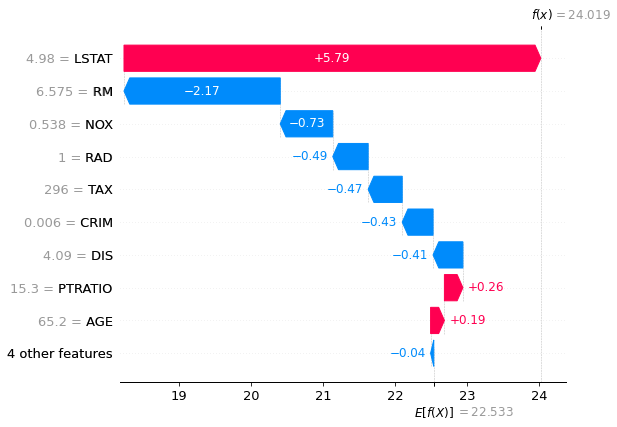

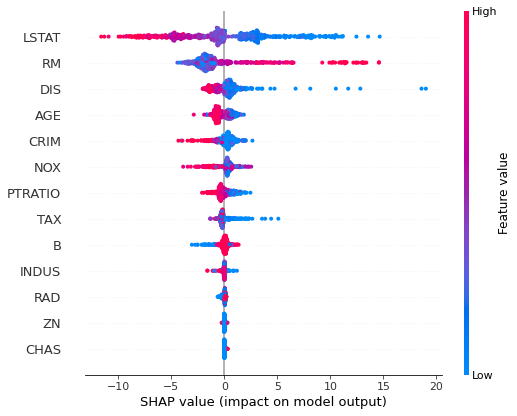

In [21]:
import xgboost
import shap

# train an XGBoost model
X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)
print(shap_values.data)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])
shap.summary_plot(shap_values, X)